In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention 

In [2]:
df=pd.read_csv(r'Respiratory_Sound_Database\diagnosis_details.csv')
df.head()

,patient_id,diagnosis,recording_index,chest_location,acquisition_mode,recording_equipment
0,101,URTI,1b1,Al,sc,Meditron
1,101,URTI,1b1,Pr,sc,Meditron
2,102,Healthy,1b1,Ar,sc,Meditron
3,103,Asthma,2b2,Ar,mc,LittC2SE
4,104,COPD,1b1,Al,sc,Litt3200


In [3]:
df.isnull().sum()

patient_id             0
diagnosis              0
recording_index        0
chest_location         0
acquisition_mode       0
recording_equipment    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           920 non-null    int64 
 1   diagnosis            920 non-null    object
 2   recording_index      920 non-null    object
 3   chest_location       920 non-null    object
 4   acquisition_mode     920 non-null    object
 5   recording_equipment  920 non-null    object
dtypes: int64(1), object(5)
memory usage: 43.2+ KB


In [5]:
#for prediction we only need first wo columns
df=df.iloc[:,:2]
df.head(1)

,patient_id,diagnosis
0,101,URTI


In [6]:
count=df['diagnosis'].value_counts()
count

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: diagnosis, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'COPD'),
  Text(1, 0, 'Pneumonia'),
  Text(2, 0, 'Healthy'),
  Text(3, 0, 'URTI'),
  Text(4, 0, 'Bronchiectasis'),
  Text(5, 0, 'Bronchiolitis'),
  Text(6, 0, 'LRTI'),
  Text(7, 0, 'Asthma')])

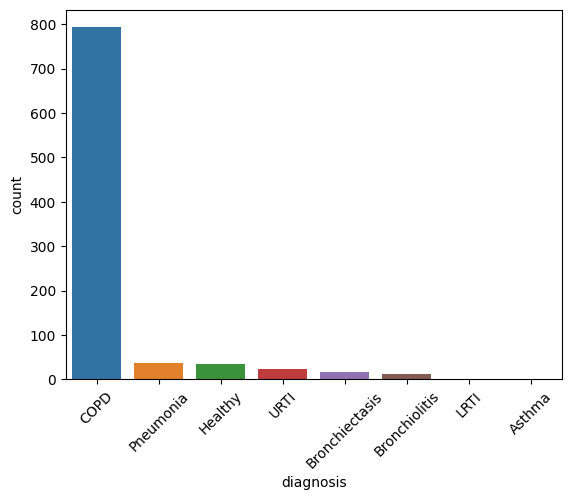

In [7]:
#we have to deal with the imbalance in our dataset
sns.countplot(x='diagnosis',data=df,order=count.index)
plt.xticks(rotation=45)

In [8]:
audio_files=glob.glob(r'Respiratory_Sound_Database\audio_and_txt_files\*.wav')
print(os.path.basename(audio_files[0]).split('_')[0])

101


In [26]:
#new_file_name = f"{os.path.splitext(audio_files[0])[0]}_aug_{np.random.randint(1000)}{os.path.splitext(audio_files[0])[1]}"
new_file_name=f"{os.path.splitext(audio_files[0])[0]}_aug_{4}{os.path.splitext(audio_files[0])[1]}"
print(new_file_name)

Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_4.wav


## Data Augmantation

In [54]:
# we will apply four types of augmentation techniques
def add_noise(data,noise_level=0.005):
    noise=np.random.random(len(data))
    augmented_data=data+noise*noise_level
    #Cast baskc data to the same data type
    augmented_data=augmented_data.astype(type(data[0]))
    return augmented_data


def stretch(data,r=1.5):
    return librosa.effects.time_stretch(data,rate=r)


def change_pitch(data,sample_rate,semitones=2):
    return librosa.effects.pitch_shift(data,sr=sample_rate,n_steps=semitones)

def change_volume(data,factor=0.5):
    return data*factor

In [ ]:
# augmentations = np.random.choice(['noise', 'stretch', 'pitch', 'volume'], size=2, replace=False)
# augmentations
augmentation_multipliers = {cls: int(np.ceil(target_samples / count)) for cls, count in class_distribution.items()}
augmentation_multipliers

In [12]:
class_distribution=count.to_dict()

#target number of samples for each class
target_samples=max(class_distribution.values())

#calculate the number of samples to add for each class
augmentation_multipliers={cls: int(np.ceil(target_samples / count)) for cls, count in class_distribution.items()}
#augrmantation_factor={k:target_samples-v for k,v in class_distribution.items()}
augmentation_multipliers

{'COPD': 1,
 'Pneumonia': 22,
 'Healthy': 23,
 'URTI': 35,
 'Bronchiectasis': 50,
 'Bronchiolitis': 61,
 'LRTI': 397,
 'Asthma': 793}

In [52]:
#function to augment the data
def augment_data(file_path,augmentations):
    y,sr=librosa.load(file_path,sr=None)
    augmented_data=y
    for augmentation in augmentations:
        if augmentation=='noise':
            augmented_data=add_noise(augmented_data)
        if augmentation=='stretch':
            augmented_data=stretch(augmented_data)
        if augmentation=='pitch':
            augmented_data=change_pitch(augmented_data,sr)
        if augmentation=='volume':
            augmented_data=change_volume(augmented_data)
    return augmented_data,sr

In [15]:
df2=pd.read_csv(r'Respiratory_Sound_Database\patient_diagnosis.csv',names=['patient_id','diagnosis'])
df2.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [57]:
new_data = augment_data(audio_files[0], ['pitch', 'volume'])
new_data


(array([ 0.04259979,  0.04973283,  0.04669041, ..., -0.01506342,
        -0.01344411, -0.01644927], dtype=float32),
 44100)

In [38]:
#creating new files with augmented data
def augment_and_label_audio(file_path,df,augmentation_multipliers):
    for f in audio_files:
        patient_id=os.path.basename(f).split('_')[0]
        diagnosis=df[df['patient_id']==int(patient_id)]['diagnosis'].values[0]
        if(diagnosis!='COPD'):
            multiplier=augmentation_multipliers[diagnosis]
            
            for i in range(multiplier):
                augmentation=np.random.choice(['noise','stretch','pitch','volume'],size=2,replace=False)
                new_data,sr=augment_data(f,augmentation)
                new_file_name=f"{os.path.splitext(f)[0]}_aug_{i}{os.path.splitext(f)[1]}"
                sf.write(new_file_name,new_data,sr)
        

In [58]:
#augment_and_label_audio(audio_files,df2,augmentation_multipliers)

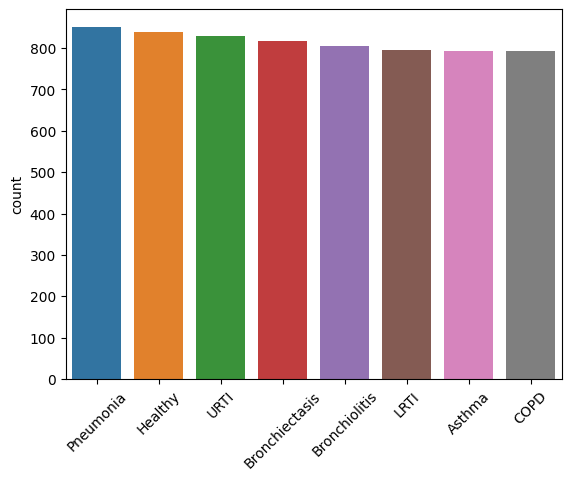

In [79]:
#checking values in new data
audio_files2=glob.glob(r'Respiratory_Sound_Database\audio_and_txt_files\*.wav')
labels2=[]
max_pad_len=926
for i in audio_files2:
    labels2.append(extract_label(i,df2))
labels2_series = pd.Series(labels2)
sns.countplot(x=labels2_series, order=labels2_series.value_counts().index)
plt.xticks(rotation=45)
plt.show()

## Feature extraction

In [90]:
#function for extracting class labels
def extract_label(file,df):
    id=os.path.basename(file).split('_')[0]
    label=df[df['patient_id']==int(id)]['diagnosis'].values[0]
    return label


#function for extracting mfcc features
def feature_extraction(file,max_pad_len,n_features):
# Load the .wav file
    audio, sample_rate = librosa.load(file)
    # Extract the MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=n_features)
    
    # If the array is shorter than max_pad_len, pad it with zeros
    if (mfccs.shape[1] < max_pad_len):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # If the array is longer than max_pad_len, truncate it
    elif (mfccs.shape[1] > max_pad_len):
        mfccs = mfccs[:, :max_pad_len]
        
    return mfccs


In [91]:
mfccs_features=[]
length=[]
labels=[]
max_pad_len=926
for i in audio_files2:
    mfccs=feature_extraction(i,max_pad_len,52)
    mfccs_features.append(mfccs)
    labels.append(extract_label(i,df2))
    length.append(mfccs.shape[1])

In [92]:
#check length size of mfccs_features
print(f'max length is {max(length)} min length is {min(length)} average length is {np.mean(length)}')
#max length is 3713 min length is 339 average length is 926.2423913043478
#we will pad the mfccs_features to 926

max length is 926 min length is 926 average length is 926.0


In [95]:
#converting fatures and labels to numpy arrays
mfccs_features=np.array(mfccs_features)
labels=np.array(labels)
print(mfccs_features.shape)
print(labels.shape)


(6524, 52, 926)
(6524,)


### Model 

In [106]:
#encoding the labels
# label_encoder=LabelEncoder()
# labels=label_encoder.fit_transform(labels)
one_hot_labels=to_categorical(labels,num_classes=8)
one_hot_labels


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [104]:
# Split the dataset into training, validation, and test sets
X_train,X_test,y_train,y_test=train_test_split(mfccs_features,one_hot_labels,test_size=0.2,random_state=0)


In [107]:
#creating model usign LSTM and attention cnn
model=Sequential([
    Input(shape=(52,926)),
    
    Conv1D(64,5,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128,3,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # LSTM layers with return_sequences=True to keep temporal dimension
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    
    # Attention Layer
    SeqSelfAttention(attention_activation='sigmoid'),
    
    # Additional LSTM Layer
    LSTM(128),
    Dropout(0.5),
    
    # Dense Layers for Classification
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\J.Abdullah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 64)            296384    
                                                                 
 batch_normalization (BatchN  (None, 52, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                        